In [3]:
from pathlib import Path
import sys

# Localizar la raíz del proyecto (carpeta que contiene `src`)
cwd = Path().resolve()
PROJECT_ROOT = None

for parent in [cwd, *cwd.parents]:
    if (parent / "src").is_dir():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró carpeta 'src' en la jerarquía.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config.settings import (
    PROJECT_ROOT as CFG_PROJECT_ROOT,
    TARGET_COL,
    RANDOM_STATE,
    MODELS_DIR,
    REPORTS_DIR,
)
from src.data.load_data import load_clean_dataset

print("PROJECT_ROOT:", CFG_PROJECT_ROOT)
print("TARGET_COL  :", TARGET_COL)
print("MODELS_DIR  :", MODELS_DIR)


PROJECT_ROOT: D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src
TARGET_COL  : Und_2a_percentage
MODELS_DIR  : D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src\data\models


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import LeakyReLU

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
sns.set(style="whitegrid")


In [5]:
# Cargar dataset limpio desde la ruta estándar
data = load_clean_dataset()
print("Shape data:", data.shape)

# X e y tal como en el experimento original
cols_to_drop_nn = ["Und_2a_percentage", "total_und", "Und_1a", "Und_2a"]
X = data.drop(cols_to_drop_nn, axis=1)
y = data[TARGET_COL]

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape data: (364832, 27)
Shape X: (364832, 23)
Shape y: (364832,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (291865, 23)
X_test : (72967, 23)
y_train: (291865,)
y_test : (72967,)


In [7]:
# Selección de variables numéricas y categóricas a partir de `data`
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()

# Eliminamos target y columnas derivadas de la parte numérica
for col in ["Und_2a_percentage", "total_und", "Und_1a", "Und_2a"]:
    if col in numerical_features:
        numerical_features.remove(col)

print("Numerical features (NN):", numerical_features)
print("Categorical features (NN):", categorical_features)

preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train_processed = preprocessor_nn.fit_transform(X_train)
X_test_processed = preprocessor_nn.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


Numerical features (NN): ['semana_anio', 'Tur', 'planta_id', 'seccion_id', 'maq_id', 'Pas', 'producto_id', 'estilo_id', 'Tal', 'Col', 'Tal_Fert', 'Col_Fert', 'Componentes', 'g_art_id', 'mp_id', 'Rechazo_comp', 'rechazo_flag']
Categorical features (NN): ['Tipo_TEJ', 'Tecnologia', 'C', 'categoria_producto', 'MP', 'mp_categoria']
X_train_processed: (291865, 179)
X_test_processed : (72967, 179)


In [8]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

def plot_metrics(history, title_prefix=""):
    metrics = ["mse", "mae"]
    available = [m for m in metrics if m in history.history]

    if not available:
        print("No hay métricas disponibles para graficar.")
        return

    fig, axes = plt.subplots(1, len(available), figsize=(6 * len(available), 4))

    if len(available) == 1:
        axes = [axes]

    for ax, metric in zip(axes, available):
        ax.plot(history.history[metric], label=f"Train {metric.upper()}")
        val_metric = f"val_{metric}"
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f"Val {metric.upper()}")

        ax.set_title(f"{title_prefix} {metric.upper()}".strip())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric.upper())
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


## Modelo 1

In [9]:
input_dim = X_train_processed.shape[1]

model1 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear"),  # regresión
    ]
)

model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,361 (122.50 KB)

 Trainable params: 31,361 (122.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 1

In [10]:
model1.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history1 = model1.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0302 - mae: 0.0783 - mape: 20342042.0000 - mse: 0.0302
Epoch 2/50
  63/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0230 - mae: 0.0689 - mape: 18362277.3810 - mse: 0.0230 

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0228 - mae: 0.0686 - mape: 17549512.0000 - mse: 0.0228
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0225 - mae: 0.0678 - mape: 17119090.0000 - mse: 0.0225
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0223 - mae: 0.0672 - mape: 16867384.0000 - mse: 0.0223
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0221 - mae: 0.0669 - mape: 16682549.0000 - mse: 0.0221
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0220 - mae: 0.0666 - mape: 16570010.0000 - mse: 0.0220
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0219 - mae: 0.0664 - mape: 16465808.0000 - mse: 0.0219
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0218 - mae: 0.0662 - mape: 16423228.0000 - mse: 0.0218
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0217 - mae: 0.0660 - mape: 16362600.0000 - mse: 0.0217
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/

### Evaluación Modelo 1

In [11]:
y_pred1 = model1.predict(X_test_processed).reshape(-1)

r2_1 = r2_score(y_test, y_pred1)
mse_1 = mean_squared_error(y_test, y_pred1)
mae_1 = mean_absolute_error(y_test, y_pred1)

print(f"[Modelo 1] R²  : {r2_1:.4f}")
print(f"[Modelo 1] MSE : {mse_1:.6f}")
print(f"[Modelo 1] MAE : {mae_1:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 2s 986us/step
[Modelo 1] R²  : 0.7942
[Modelo 1] MSE : 0.022403
[Modelo 1] MAE : 0.065421


## Modelo 2

In [12]:
model2 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),   # capa adicional
        layers.Dropout(0.2),                   # regularización
        layers.Dense(1, activation="linear"),
    ]
)

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,409 (130.50 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 2

In [13]:
model2.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history2 = model2.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0288 - mae: 0.0868 - mape: 20910672.0000 - mse: 0.0288
Epoch 2/50
  62/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0274 - mae: 0.0821 - mape: 17801732.8226 - mse: 0.0274

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0249 - mae: 0.0799 - mape: 18882776.0000 - mse: 0.0249
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0245 - mae: 0.0789 - mape: 18469038.0000 - mse: 0.0245
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0243 - mae: 0.0784 - mape: 18199650.0000 - mse: 0.0243
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0240 - mae: 0.0778 - mape: 18034136.0000 - mse: 0.0240
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0239 - mae: 0.0777 - mape: 17946386.0000 - mse: 0.0239
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0239 - mae: 0.0776 - mape: 17916900.0000 - mse: 0.0239
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0237 - mae: 0.0773 - mape: 17812394.0000 - mse: 0.0237
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0236 - mae: 0.0768 - mape: 17738032.0000 - mse: 0.0236
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/

### Evaluación Modelo 2

In [14]:
y_pred2 = model2.predict(X_test_processed).reshape(-1)

r2_2 = r2_score(y_test, y_pred2)
mse_2 = mean_squared_error(y_test, y_pred2)
mae_2 = mean_absolute_error(y_test, y_pred2)

print(f"[Modelo 2] R²  : {r2_2:.4f}")
print(f"[Modelo 2] MSE : {mse_2:.6f}")
print(f"[Modelo 2] MAE : {mae_2:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step
[Modelo 2] R²  : 0.7941
[Modelo 2] MSE : 0.022419
[Modelo 2] MAE : 0.066049


## Modelo 3 (LeakyReLU)

In [15]:
model3 = keras.Sequential(
    [
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation=LeakyReLU(alpha=0.2)),
        layers.Dense(64, activation=LeakyReLU(alpha=0.2)),
        layers.Dense(32, activation=LeakyReLU(alpha=0.2)),
        layers.Dropout(0.2),
        layers.Dense(1, activation="linear"),
    ]
)

model3.summary()


d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,409 (130.50 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Modelo 3

In [16]:
model3.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse", "mae", "mape"],
)

history3 = model3.fit(
    X_train_processed,
    y_train,
    epochs=25,          # igual que el original
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0339 - mae: 0.0900 - mape: 21958954.0000 - mse: 0.0339
Epoch 2/25
  70/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0287 - mae: 0.0825 - mape: 20165825.8571 - mse: 0.0287

d:\Users\dhcertug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0246 - mae: 0.0785 - mape: 19073460.0000 - mse: 0.0246
Epoch 3/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0240 - mae: 0.0767 - mape: 18441854.0000 - mse: 0.0240
Epoch 4/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0237 - mae: 0.0758 - mape: 18113370.0000 - mse: 0.0237
Epoch 5/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0235 - mae: 0.0754 - mape: 17919914.0000 - mse: 0.0235
Epoch 6/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0234 - mae: 0.0750 - mape: 17761344.0000 - mse: 0.0234
Epoch 7/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0233 - mae: 0.0748 - mape: 17646238.0000 - mse: 0.0233
Epoch 8/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0232 - mae: 0.0747 - mape: 17554834.0000 - mse: 0.0232
Epoch 9/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0232 - mae: 0.0746 - mape: 17518216.0000 - mse: 0.0232
Epoch 10/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/

### Evaluación Modelo 3

In [17]:
y_pred3 = model3.predict(X_test_processed).reshape(-1)

r2_3 = r2_score(y_test, y_pred3)
mse_3 = mean_squared_error(y_test, y_pred3)
mae_3 = mean_absolute_error(y_test, y_pred3)

print(f"[Modelo 3] R²  : {r2_3:.4f}")
print(f"[Modelo 3] MSE : {mse_3:.6f}")
print(f"[Modelo 3] MAE : {mae_3:.6f}")


2281/2281 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
[Modelo 3] R²  : 0.7943
[Modelo 3] MSE : 0.022388
[Modelo 3] MAE : 0.071126


## Curvas de entrenamiento

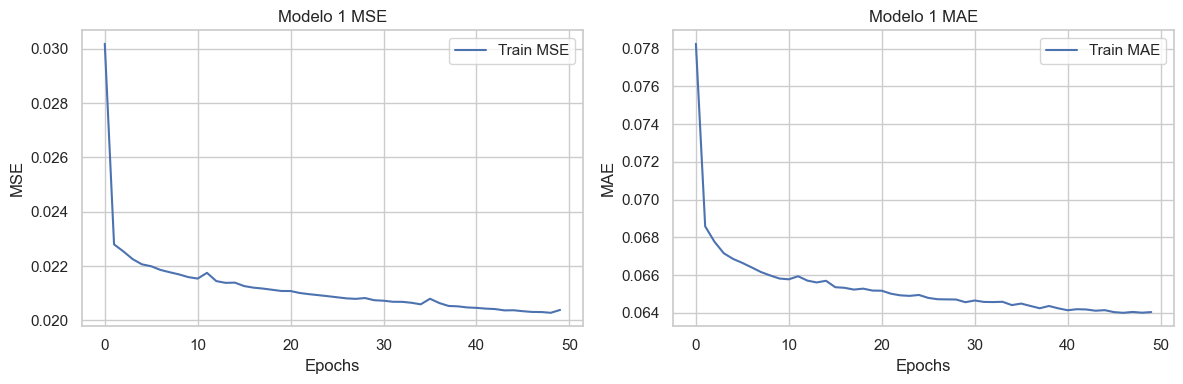

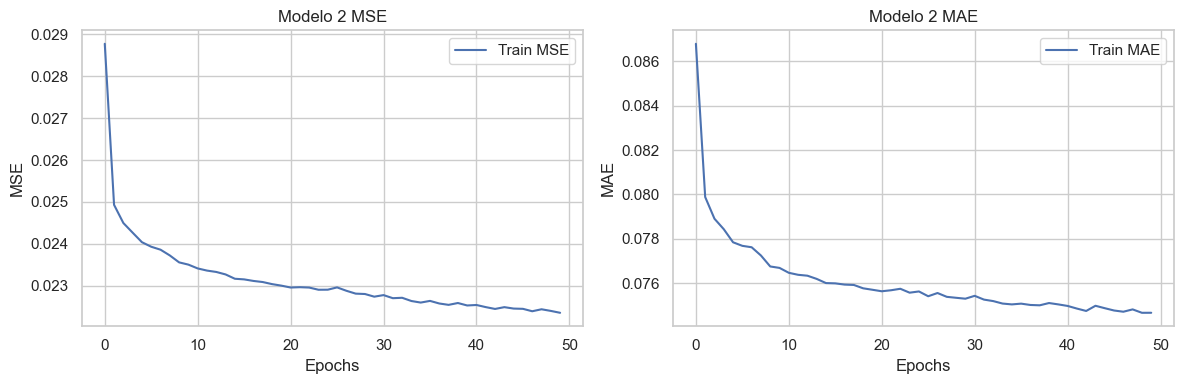

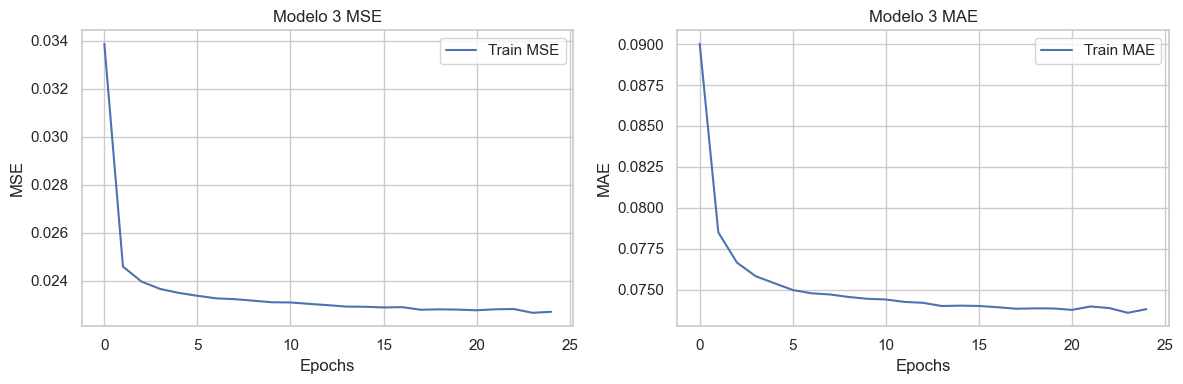

In [18]:
plot_metrics(history1, title_prefix="Modelo 1")
plot_metrics(history2, title_prefix="Modelo 2")
plot_metrics(history3, title_prefix="Modelo 3")


## Modelo 4: XGBoost

In [19]:
# Volvemos a usar X tal como fue definido para los modelos NN (mismas columnas)
num_features_xgb = X.select_dtypes(include=["int64", "float64"]).columns
cat_features_xgb = X.select_dtypes(include=["object"]).columns

print("Numeric features (XGB):", list(num_features_xgb))
print("Categorical features (XGB):", list(cat_features_xgb))

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_xgb),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features_xgb),
    ]
)


Numeric features (XGB): ['semana_anio', 'Tur', 'planta_id', 'seccion_id', 'maq_id', 'Pas', 'producto_id', 'estilo_id', 'Tal', 'Col', 'Tal_Fert', 'Col_Fert', 'Componentes', 'g_art_id', 'mp_id', 'Rechazo_comp', 'rechazo_flag']
Categorical features (XGB): ['Tipo_TEJ', 'Tecnologia', 'C', 'categoria_producto', 'MP', 'mp_categoria']


In [20]:
xgb_model = XGBRegressor(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.3,
    reg_lambda=1.5,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1,
)

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_xgb),
        ("model", xgb_model),
    ]
)


In [21]:
# Ordenar por semana y hacer split temporal 80/20
df_sorted = data.sort_values("semana_anio")

split_week = df_sorted["semana_anio"].quantile(0.8)

train_df = df_sorted[df_sorted["semana_anio"] <= split_week]
test_df  = df_sorted[df_sorted["semana_anio"] >  split_week]

X_train_xgb = train_df.drop("Und_2a_percentage", axis=1)
y_train_xgb = train_df["Und_2a_percentage"]

X_test_xgb = test_df.drop("Und_2a_percentage", axis=1)
y_test_xgb = test_df["Und_2a_percentage"]

print("X_train_xgb:", X_train_xgb.shape)
print("X_test_xgb :", X_test_xgb.shape)

# Filtrado de outliers en la variable objetivo
q_low  = y_train_xgb.quantile(0.01)
q_high = y_train_xgb.quantile(0.99)
mask = (y_train_xgb >= q_low) & (y_train_xgb <= q_high)

X_train_xgb = X_train_xgb[mask]
y_train_xgb = y_train_xgb[mask]

print("X_train_xgb (filtrado):", X_train_xgb.shape)


X_train_xgb: (296717, 26)
X_test_xgb : (68115, 26)
X_train_xgb (filtrado): (296717, 26)


### Entrenar XGBoost y evaluar

In [22]:
pipeline_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = pipeline_xgb.predict(X_test_xgb)

mae_xgb  = mean_absolute_error(y_test_xgb, y_pred_xgb)
mse_xgb  = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb   = r2_score(y_test_xgb, y_pred_xgb)

print(f"[XGB] MAE : {mae_xgb:.6f}")
print(f"[XGB] RMSE: {rmse_xgb:.6f}")
print(f"[XGB] MSE : {mse_xgb:.6f}")
print(f"[XGB] R²  : {r2_xgb:.4f}")


[XGB] MAE : 0.069951
[XGB] RMSE: 0.148136
[XGB] MSE : 0.021944
[XGB] R²  : 0.7923


In [23]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)

xgb_experiment_path = MODELS_DIR / "modelo_xgb_und2a_04_experimentos.pkl"
joblib.dump(pipeline_xgb, xgb_experiment_path)

xgb_experiment_path


WindowsPath('D:/Users/dhcertug/OneDrive - Crystal S.A.S/Documentos/HOME/00_PERSONAL/02_CURSOS/PROYECTO/Proyecto_analisis_intermedio_udea/src/data/models/modelo_xgb_und2a_04_experimentos.pkl')

### Resumen de modelos clásicos

In [24]:

summary = pd.DataFrame(
    {
        "model": ["nn_dense_1", "nn_dense_2", "nn_dense_3", "xgb_baseline"],
        "R2":    [r2_1,        r2_2,        r2_3,        r2_xgb],
        "MSE":   [mse_1,       mse_2,       mse_3,       mse_xgb],
        "MAE":   [mae_1,       mae_2,       mae_3,       mae_xgb],
    }
)

display(summary)


REPORTS_DIR.mkdir(parents=True, exist_ok=True)
comp_path = REPORTS_DIR / "model_comparison.csv"

# Filas nuevas para anexar al CSV global
new_rows = [
    {
        "model": "nn_dense_1",
        "R2": float(r2_1),
        "RMSE": float(np.sqrt(mse_1)),
        "MSE": float(mse_1),
        "MAE": float(mae_1),
    },
    {
        "model": "nn_dense_2",
        "R2": float(r2_2),
        "RMSE": float(np.sqrt(mse_2)),
        "MSE": float(mse_2),
        "MAE": float(mae_2),
    },
    {
        "model": "nn_dense_3",
        "R2": float(r2_3),
        "RMSE": float(np.sqrt(mse_3)),
        "MSE": float(mse_3),
        "MAE": float(mae_3),
    },
    {
        "model": "xgb_baseline",
        "R2": float(r2_xgb),
        "RMSE": float(rmse_xgb),
        "MSE": float(mse_xgb),
        "MAE": float(mae_xgb),
    },
]

if comp_path.exists():
    comp_df = pd.read_csv(comp_path)

    # Evitar duplicar entradas si vuelves a ejecutar el notebook
    existing_models = set(comp_df["model"].astype(str))
    filtered_rows = [r for r in new_rows if r["model"] not in existing_models]

    if filtered_rows:
        comp_df = pd.concat(
            [comp_df, pd.DataFrame(filtered_rows)],
            ignore_index=True,
        )
else:
    comp_df = pd.DataFrame(new_rows)

comp_df.to_csv(comp_path, index=False)
print("✅ Model comparison actualizado en:", comp_path)


,model,R2,MSE,MAE
0,nn_dense_1,0.794200,0.022403,0.065421
1,nn_dense_2,0.794056,0.022419,0.066049
2,nn_dense_3,0.794336,0.022388,0.071126
3,xgb_baseline,0.792339,0.021944,0.069951


✅ Model comparison actualizado en: D:\Users\dhcertug\OneDrive - Crystal S.A.S\Documentos\HOME\00_PERSONAL\02_CURSOS\PROYECTO\Proyecto_analisis_intermedio_udea\src\reports\model_comparison.csv
